In [1]:
import json
import codecs
from operator import itemgetter
import re
import pandas as pd
import matplotlib.pyplot as plt 
import squarify 
import networkx as nx
import datetime
import matplotlib.dates as mdates

The following code will load only events gathered in the honeypot that have included a command.

In [2]:
f = open('cowrie-all-logs_clean.json', "r")
# f = open('cowrie-all-logs-20201113_clean_lite.json', "r")

df = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input'])
df_src_ip = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input'])


# separators_re = re.compile(';[^\}]|\|\||\&\&|\|')
separators_re = re.compile(';[^\}]|\||\|\||\&\&')

space_re = re.compile(' ')

for l in f.readlines():
            try:
                a = json.loads(l)
                if ((a['eventid'] == 'cowrie.command.input')):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                 
                    # Migrate into pandas explode method
                    if (b['input'].strip() != 'Enter new UNIX password:'):
                        splitted = separators_re.split(b['input'])
                        for i in splitted:
                            
                            b['input'] = space_re.split(i.strip())[0]         
                            removelist = '/._-'
                            b['input'] = re.sub(r'[^\w'+removelist+']', '', b['input'])
                            
                            if b['input'] != '':
                                # print('b: ' + str(b))
                                df = df.append(b, ignore_index=True)
                else:
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    df_src_ip = df_src_ip.append(b, ignore_index=True)

            except Exception as e:
                pass
                #print("exception: " + str(e))
                #print(l)

df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%dT%H:%M:%S.%fz')
df = df.sort_values('timestamp')               

In [3]:
df

,eventid,src_ip,session,timestamp,sensor,input
0,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.906679,b51dd385f9bd,enable
1,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.909020,b51dd385f9bd,system
2,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.911743,b51dd385f9bd,shell
3,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.913665,b51dd385f9bd,sh
4,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.978229,b51dd385f9bd,cat
...,...,...,...,...,...,...
172600,cowrie.command.input,167.71.196.176,310ece4a7d50,2020-12-31 23:59:58.816049,9bb211abc05d,echo
172603,cowrie.command.input,167.71.196.176,310ece4a7d50,2020-12-31 23:59:59.425048,9bb211abc05d,grep
172604,cowrie.command.input,167.71.196.176,310ece4a7d50,2020-12-31 23:59:59.425048,9bb211abc05d,head
172602,cowrie.command.input,167.71.196.176,310ece4a7d50,2020-12-31 23:59:59.425048,9bb211abc05d,cat


In [4]:
print(len(df_src_ip))

2895


In [5]:
len(df.index)

172606

In [6]:
df.head()

,eventid,src_ip,session,timestamp,sensor,input
0,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.906679,b51dd385f9bd,enable
1,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.909020,b51dd385f9bd,system
2,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.911743,b51dd385f9bd,shell
3,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.913665,b51dd385f9bd,sh
4,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12 01:40:04.978229,b51dd385f9bd,cat


**Analytics cases:**

- **Top commands received:**

In [7]:
df['input'].value_counts()[:15]

grep       29663
cat        15386
uname      14826
echo       12632
cd          9957
wc          9866
awk         9863
rm          5037
passwd      4992
ls          4984
head        4982
bash        4956
chmod       4946
free        4929
crontab     4928
Name: input, dtype: int64

Treemap of all commands

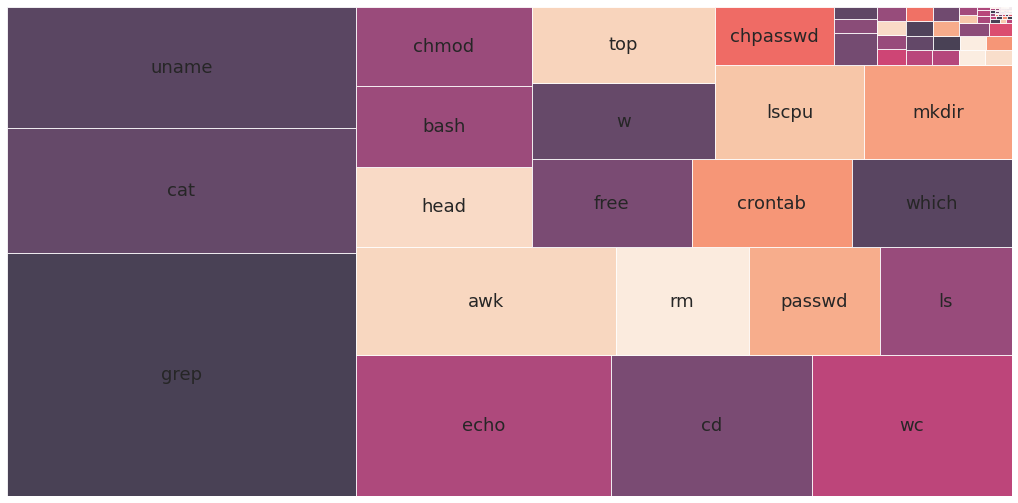

In [58]:
df['input'].value_counts()[:25]
squarify.plot(sizes = df['input'].value_counts(), 
              label = df['input'].value_counts()[:21].index, alpha = 0.8, 
              text_kwargs={'fontsize':18})
plt.axis('off')
plt.show()

As analyzed, most of the commands shown in the most common are used to query or search for information about the honeypot. 
Some of them are more intrusive, trying to change the users passwords or attempting to validate the users permissions. 
These commands are commonly used to identify if the system is a honeypot.

- **Number of relevant download commands (interesting from a honeypot perspective)**

In [9]:
print('wget events: ' + str(df['input'].value_counts()['wget']))
print('tftp events: ' + str(df['input'].value_counts()['tftp']))
print('curl events: ' + str(df['input'].value_counts()['curl']))
print('nc events: ' + str(df['input'].value_counts()['nc']))

print('scp events: ' + str(df['input'].value_counts()['scp']))
# print('sftp events: ' + str(df['input'].value_counts()['sftp']))
# print('ssh events: ' + str(df['input'].value_counts()['ssh']))
print('ftpget events: ' + str(df['input'].value_counts()['ftpget']))

wget events: 188
tftp events: 168
curl events: 31
nc events: 5
scp events: 7
ftpget events: 5


In [10]:
print('frequency of wget command: ' + str(df['input'].value_counts(normalize = True)['wget']))
print('frequency of grep command: ' + str(df['input'].value_counts(normalize = True)['grep']))

frequency of wget command: 0.0010891857756972526
frequency of grep command: 0.17185381736440217


The commands are significant for setting up an adaptive honeypot which prioritizes the download of malicious software from the attackers. Software components provide valuable information on the attackers techniques.
The configurations used in irassh and qrassh target those by default, assigning a reward function that targets actions which will lead the attacker to submit these commands.

The number of commands that imply a download action are limited in numbers, for instance 'wget' being a 0,001% of the total number of commands gathered. As a comparison, 'grep' accounts for a 17% of the total commands gathered.

This fact means that a long period of time is necessary for the honeypot learning agent to optimize its behaviour and lead the attackers to perform download actions.

- **Longest interactions between attacker and honeypot**

Basic statistic analysis on session counts

In [11]:
print(df['session'].value_counts().mean())
print(df['session'].value_counts().median())

31.607031679179638
33.0


              session
1c03e3e1b21b       52
9dfa844ed998       49
3babd17be854       49
2201c10eee03       49
0c6bbbcfb298       49
...               ...
8f72973d97cd        1
b6144fa9771e        1
edbfe8cd9ac4        1
e03327a834ef        1
105d8b6dc36e        1

[5461 rows x 1 columns]


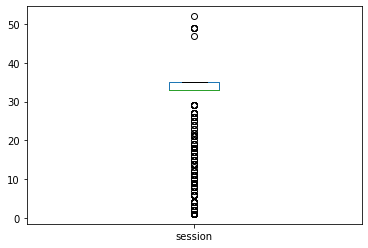

In [12]:
sessions = pd.DataFrame(df['session'].value_counts())
print(sessions)
ax = sessions.plot.box()

In [13]:
longest = df['session'].value_counts()[:100]
print(longest.to_dict())


{'1c03e3e1b21b': 52, '9dfa844ed998': 49, '3babd17be854': 49, '2201c10eee03': 49, '0c6bbbcfb298': 49, 'eeaf8ca0a41f': 49, '67b7252c046f': 47, 'e4f2466b5fc0': 35, 'ee937892d3cb': 35, 'a796ab671d32': 35, '31fb94063d76': 35, 'ffa727a2b2e6': 35, '0008d9a37a7b': 35, '2650ce427820': 35, '9aef0ea85776': 35, '38fb757b4aed': 35, 'fe470ab3fe96': 35, '5f201f6b6cf4': 35, '156e185d2c09': 35, '86683e2971be': 35, '38a73b89e312': 35, '0af5a61f1806': 35, '9b6dc51f8405': 35, '2fdf28749fec': 35, 'c39d9d7f35a3': 35, 'd231f7869683': 35, 'ee6741f0b775': 35, 'b3ccc4f937a3': 35, '29ba1addfccc': 35, '11809f32bbbf': 35, '24580021d88c': 35, 'b3e8a394ce9e': 35, '19dc4d021863': 35, 'b54aee57486f': 35, 'a4b53c401e46': 35, 'f1951b0aa537': 35, 'cf266aa1572d': 35, '013e42eee52d': 35, '3e905253887d': 35, 'c294b717bcd7': 35, '12f080896f89': 35, 'd7b57f314200': 35, 'c8b8e5a06c9a': 35, 'c8849805c921': 35, 'b67e69e08973': 35, '4249fadc98f1': 35, '40a6779366fc': 35, '396b3450bdf6': 35, '6b532f49f913': 35, '29cdd06b7b18': 35,

The statistics analysis of session counts reveals that the median number of commands per session is 34. The boxplot analysis shows that most of these sessions have been centered around this value. 

A possible explanation for this consists on the hypothesis that most of the attacks have been performed by individuals using a specific automated tool or a similar set of tools.

In [14]:
print(df['session'].value_counts()[:500])
print(df['session'].value_counts()[:500].value_counts())

1c03e3e1b21b    52
9dfa844ed998    49
3babd17be854    49
2201c10eee03    49
0c6bbbcfb298    49
                ..
593a7581bbd6    35
ac5a57ea8397    35
5a228651a5ea    35
e7acc58d17ce    35
c139d1a67628    35
Name: session, Length: 500, dtype: int64
35    493
49      5
52      1
47      1
Name: session, dtype: int64


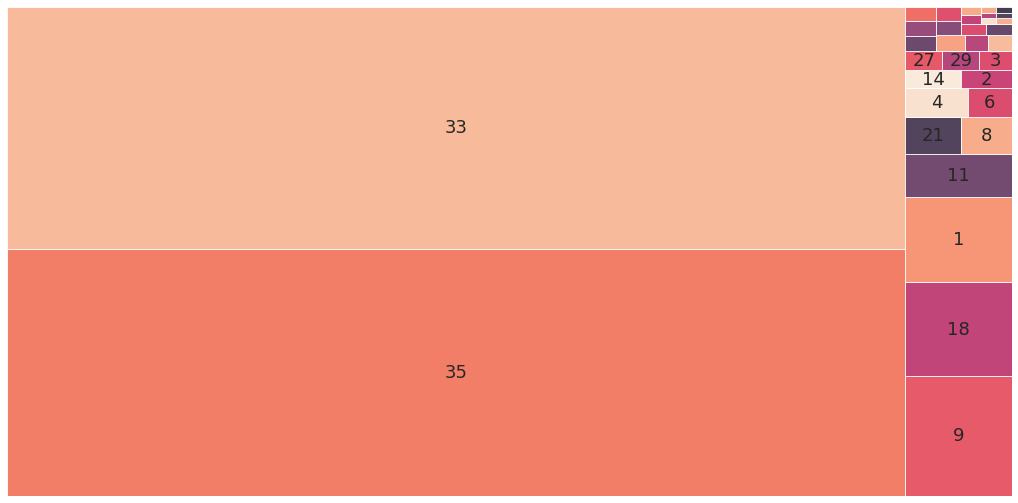

In [63]:
squarify.plot(sizes = df['session'].value_counts().value_counts(), 
              label = df['session'].value_counts().value_counts()[:15].index, alpha =.8, 
              text_kwargs={'fontsize':18})
plt.axis('off')
plt.show()

Indeed, a large number of interactions have 33 or 35 commands recorded. A large number of those are interactions which at some point have a command input consisting on a number of composed commands with bash separators (&& || | ;) that allow for several commands to be executed out of a single bash line.

I perform a study of the attack origins, with the aim of checking if the actors connecting to the honeypot in the context of this long sessions seem to be related.

In [16]:
df[df['session'] == '870ddd11ea6a']['src_ip']


src_ips = {}
for l in longest.to_dict().keys():
    
    ip = df[df['session'] == l].iloc[0]['src_ip']
    
    if ip in src_ips:
        src_ips[ip] += 1
    else:
        src_ips[ip] = 1

print(dict(sorted(src_ips.items(), key=lambda item: item[1])))
    

{'80.229.157.225': 1, '163.172.198.85': 1, '120.253.167.238': 1, '138.197.166.66': 1, '140.143.95.102': 1, '5.196.69.227': 1, '106.13.105.97': 1, '106.12.207.92': 1, '165.22.68.84': 1, '129.28.193.59': 1, '190.156.231.245': 1, '130.61.184.220': 1, '192.241.249.226': 1, '190.202.124.93': 1, '154.8.232.15': 1, '182.254.161.202': 1, '58.33.49.196': 1, '162.14.18.58': 1, '139.99.155.219': 1, '37.59.58.8': 1, '119.45.221.79': 1, '185.222.7.221': 1, '91.218.67.103': 1, '129.204.45.118': 1, '20.46.114.59': 1, '61.132.52.35': 1, '157.230.190.90': 1, '54.37.64.149': 1, '211.159.163.166': 1, '198.245.50.81': 1, '51.68.44.13': 1, '111.229.211.66': 1, '64.52.85.184': 1, '62.210.14.172': 1, '42.192.79.87': 1, '114.67.85.74': 1, '51.178.142.175': 1, '138.68.24.88': 1, '83.118.200.190': 1, '36.155.115.72': 1, '202.165.22.141': 1, '139.59.3.114': 1, '119.29.191.217': 1, '134.209.146.100': 1, '139.199.124.131': 1, '185.17.141.64': 1, '101.89.188.88': 1, '109.125.136.233': 1, '206.189.180.178': 1, '115.

In [17]:
pd.options.display.max_colwidth = 500


Most sessions (except 9 of them) have each a different source IP address connecting to the honeypot. This fact leads to the conclusion that the agents are either different, or automating the attacks from different source ips. 

At least, the possibility of the exact same agent from the same host attacking the honeypot repeatedly can be discarded. It seems more feasible to assume that a number of unrelated agents might be attacking the honeypot.

In [18]:
f = open('cowrie-all-logs_clean.json', "r")
# f = open('cowrie-all-logs-20201113_clean_lite.json', "r")
# f = open('cowrie-all-logs-20201113_clean_lite_lite.json', "r")

df_composed = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input', 'num_commands'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

total_commands_lines = 0

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'cowrie.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    total_commands_lines = total_commands_lines + 1
                    
                    if (b['input'].strip() != 'Enter new UNIX password:'):
                        if (separators_re.search(b['input'])):
                            splitted = separators_re.split(b['input']) 
                            b['num_commands'] = len(splitted)
                            
                            df_composed = df_composed.append(b, ignore_index=True)
                    
            except Exception as e:
                print("error: " + str(e))
                print(l)
                

error: Expecting ':' delimiter: line 1 column 120 (char 119)
{"eventid":"cowrie.client.version","version":"b'SSH-2.0-Go'","message":"Remote SSH version: b'SSH-2.0-Go'","aes256-ctr","aes128-gcm@openssh.com","chacha20-poly1305@openssh.com","arcfour256","arcfour128","arcfour","aes128-cbc","3des-cbc","aes128-gcm@openssh.com","aes128-cbc"],"macCS":["hmac-sha2-256-etm@openssh.com","hmac-sha2-256","hmac-sha1","hmac-sha1-96"],"compCS":["none"],"langCS":[""],"message":"SSH client hassh fingerprint: 01ca35584ad5a1b66cf6a9846b5b2821","sensor":"2262e8f7cb5d","timestamp":"2020-11-01T01:49:55.174279Z","src_ip":"175.196.191.156","session":"5ecf1be05c15"}

error: Expecting ':' delimiter: line 1 column 95 (char 94)
{"eventid":"cowrie.client.kex","hassh":"eccf733a56108dec8ecc8efbc681be63","ecdh-sha2-nistp256","ecdh-sha2-nistp384","ecdh-sha2-nistp521","diffie-hellman-group14-sha1","diffie-hellman-group1-sha1"],"keyAlgs":["ssh-rsa-cert-v01@openssh.com","ssh-dss-cert-v01@openssh.com","ecdsa-sha2-nistp256-c

error: Expecting ',' delimiter: line 1 column 586 (char 585)
{"eventid":"cowrie.client.kex","hassh":"2f300334eb474e4d5ef932343447dd80","hasshAlgorithms":"curve25519-sha256@libssh.org,ecdh-sha2-nistp256,ecdh-sha2-nistp384,ecdh-sha2-nistp521,diffie-hellman-group14-sha1,diffie-hellman-group1-sha1;aes128-ctr,aes192-ctr,aes256-ctr,aes128-gcm@openssh.com,arcfour256,arcfour128,aes128-cbc,arcfour,3des-cbc;hmac-sha2-256-etm@openssh.com,hmac-sha2-256,hmac-sha1,hmac-sha1-96;none","kexAlgs":["curve25519-sha256@libssh.org","ecdh-sha2-nistp256","ecdh-sha2-nistp384","ecdh-sha2-nistp521","diffie-hellman-group14-sha1","diffie-hellman-group1-sha1","sensor":"8c1fa33cb54e","timestamp":"2020-11-09T20:52:03.180493Z","src_ip":"200.130.99.116","session":"b543c0d13c2f"}

error: Expecting ',' delimiter: line 1 column 501 (char 500)
{"eventid":"cowrie.client.kex","hassh":"98ddc5604ef6a1006a2b49a58759fbe6","hasshAlgorithms":"curve25519-sha256@libssh.org,ecdh-sha2-nistp256,ecdh-sha2-nistp384,ecdh-sha2-nistp521,dif

In [19]:
print('Session c905b8d75cb4\n')
print(df_composed[df_composed['session'] == 'c905b8d75cb4']['input'])
print('\nSession d53418516393\n')
print(df_composed[df_composed['session'] == 'd53418516393']['input'])


Session c905b8d75cb4

33635                                                                                                                                                                                                                                                                                                                                                                                                                                                                    cat /proc/cpuinfo | grep name | wc -l
33636                                                                                                                                                                                                                                                                                                                                                                                                                                                                   echo "root:2c6z9x4hmM2S"|ch

In [20]:
print('Session 47f0930efe34\n')
print(df_composed[df_composed['session'] == '47f0930efe34']['input'])
print('\nSession 824a4db7fa66\n')
print(df_composed[df_composed['session'] == '824a4db7fa66']['input'])

Session 47f0930efe34

34535                                                                                                                                                                                                                                                                                                                                                                                                                                                                    cat /proc/cpuinfo | grep name | wc -l
34536                                                                                                                                                                                                                                                                                                                                                                                                                                                 echo -e "friday\nu2maKqpFgxaJ\nu2maKqpFgxaJ"|

In [21]:
len(df_composed.index)

37906

In [22]:
df_composed.head()

,eventid,src_ip,session,timestamp,sensor,input,num_commands
0,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12T01:40:04.978229Z,b51dd385f9bd,cat /proc/mounts; /bin/busybox FFVBM,2
1,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12T01:40:05.060357Z,b51dd385f9bd,cd /dev/shm; cat .s || cp /bin/echo .s; /bin/busybox FFVBM,5
2,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12T01:40:05.130160Z,b51dd385f9bd,tftp; wget; /bin/busybox FFVBM,3
3,cowrie.command.input,185.140.102.121,ab7d16c2799c,2020-10-12T01:40:05.198901Z,b51dd385f9bd,dd bs=52 count=1 if=.s || cat .s || while read i; do echo $i; done < .s,7
4,cowrie.command.input,71.38.44.223,9b3f39ff2260,2020-10-17T08:09:32.753347Z,4e18ce1c6e92,ps | grep '[Mm]iner',2


In [23]:
print(total_commands_lines)

80982


75K lines in the original honeypot file contain one or more commands issued.

In [24]:
### percentage of composed commands over total

print('Proportion of composed commands over total is: ' + 
      str(len(df_composed.index)/total_commands_lines*100) + '%')



Proportion of composed commands over total is: 46.80793262700353%


Almost 50% of them are composed lines (more than one command, with one or more separators).

I perform a deeper study on the composed commands. 

In [25]:
print(df_composed['num_commands'].value_counts()[:50])

3     14959
4      9864
2      7773
6      4859
10      141
5       139
7       136
16       14
8         9
15        4
34        2
20        2
12        2
52        1
23        1
Name: num_commands, dtype: int64


In [26]:
lessthan6 = df_composed[df_composed['num_commands'] <= 6]['num_commands'].count()
lessthan6

37594

In [27]:
print('Proportion of composed commands with 6 or less commands over total is: ' + 
      str(lessthan6/len(df_composed.index)*100) + '%')

Proportion of composed commands with 6 or less commands over total is: 99.17691130691712%


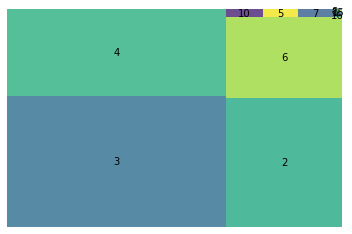

In [28]:
squarify.plot(sizes = df_composed['num_commands'].value_counts(), 
              label = df_composed['num_commands'].value_counts()[:8].index, alpha =.8)
plt.axis('off')
plt.show()

The most common values, both as a list and a treemap reveal that the most common values (above the 99,5% of the cases) are 6 or less commands. This value discards that the sessions with a long number of commands (33 and 35) are consisting on composed commands.

- **Commands issued in longest sessions**

In [29]:
# Assemble dataset with commands in longest sessions. This will be used in the reinforcement learning reward

df_cmd = pd.DataFrame()
i = 0
for session in longest.to_dict():
    
    # print(session)
    # print(df.loc[df['session'] == session])
    
    for row in (df.loc[df['session'] == session].iterrows()):
        df_cmd = df_cmd.append({'session': row[1]['session'], 'input': row[1]['input']}, ignore_index=True)


In [30]:
print(len(df_cmd.index))

3599


In [31]:
df_cmd['input'].unique()

array(['/usr/sbin/ifconfig', 'echo', 'cat', 'lastlog', 'sudo', 'crontab',
       '/usr/sbin/arp', 'mkdir', 'uname', 'uptime', 'w', 'who', 'last',
       'exit', 'ls', 'ps', 'netstat', 'grep', 'wc', 'passwd', 'bash',
       'rm', 'head', 'awk', 'free', 'which', 'top', 'lscpu', 'base64',
       'sleep', 'cd', 'chmod', 'chpasswd'], dtype=object)

In [32]:
df_counts_sessions = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df

for row in df2.iterrows():
    
    # for each different session (each line one session)
    # if not it the new df_counts_sessions dataframe, count and insert
    if (row[1]['session'] not in df_counts_sessions['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        n = df2.loc[df2['session'] == row[1]['session']].shape[0]

        if (n != 33 and n!= 35):  ### manual removal of a noisy attacker
            df_counts_sessions = df_counts_sessions.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    
    
df_counts_sessions.timestamp = pd.to_datetime(df_counts_sessions.timestamp, format='%Y-%m-%d')
df_counts_sessions = df_counts_sessions.sort_values('timestamp')   
df_counts_sessions = df_counts_sessions.set_index('timestamp')
    
df_counts_sessions

,session,n
timestamp,,
2020-10-12,ab7d16c2799c,18
2020-10-17,9b3f39ff2260,11
2020-10-17,f7f6ed4c7267,2
2020-10-17,3b6caf0f2bcd,18
2020-10-17,f0b9c9a76373,18
...,...,...
2020-12-30,275cbad16081,2
2020-12-31,5e63a5a7ffba,1
2020-12-31,48b66e5c4f08,21


In [33]:
df_counts_sessions.max()

session    fff9d8f89966
n                    52
dtype: object

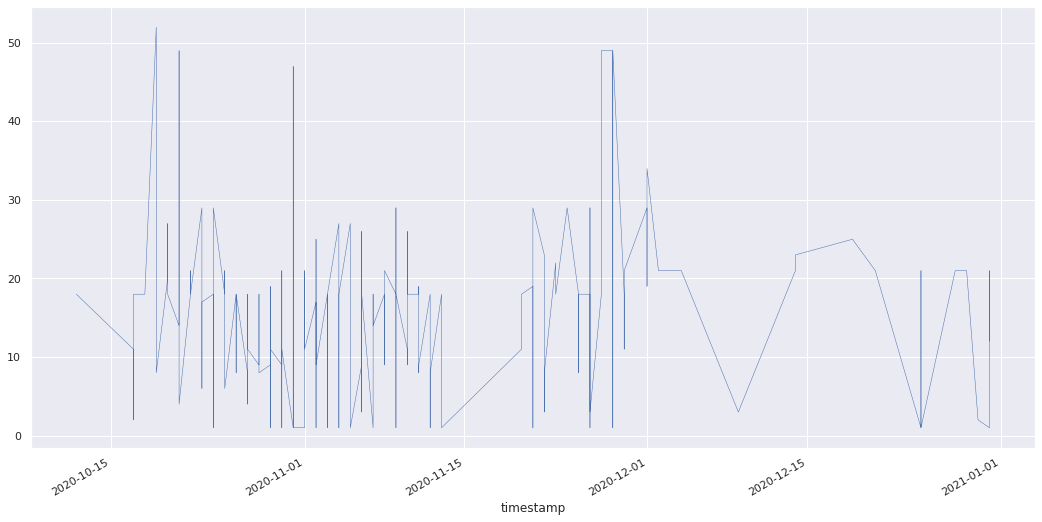

In [34]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 9)})

# plot length of sessions over time. 
# get ranges of time (days?) and plat mean or max session length? 

# better draw a line for median and columns for max. Even better, points like F in columns

df_counts_sessions['n'].plot(linewidth=0.5);



An improvement over the past graphic can be used by plotting the number of commands per session on dots. Each session on a day is represented with its length (number of commands) as a dot.

The darker they appear, the more sessions with that particular number of commands have been recorded for a given day.

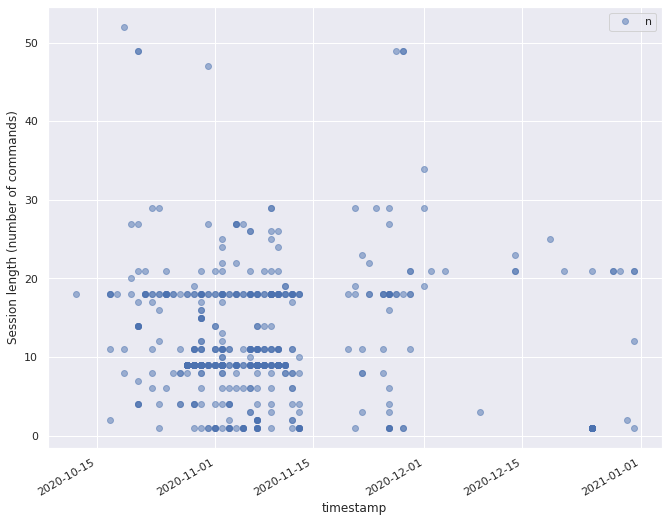

In [35]:
cols_plot = ['session', 'n']
axes = df_counts_sessions[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Session length (number of commands)')

In [36]:
# df_counts_sessions.dtypes
# df_counts_sessions.astype({'n': 'int'}).dtypes

daily_mean_sessions = df_counts_sessions.astype({'n': 'int'}).resample('D').mean()
daily_mean_sessions


,n
timestamp,
2020-10-12,18.00
2020-10-13,NaN
2020-10-14,NaN
2020-10-15,NaN
2020-10-16,NaN
...,...
2020-12-27,NaN
2020-12-28,21.00
2020-12-29,21.00


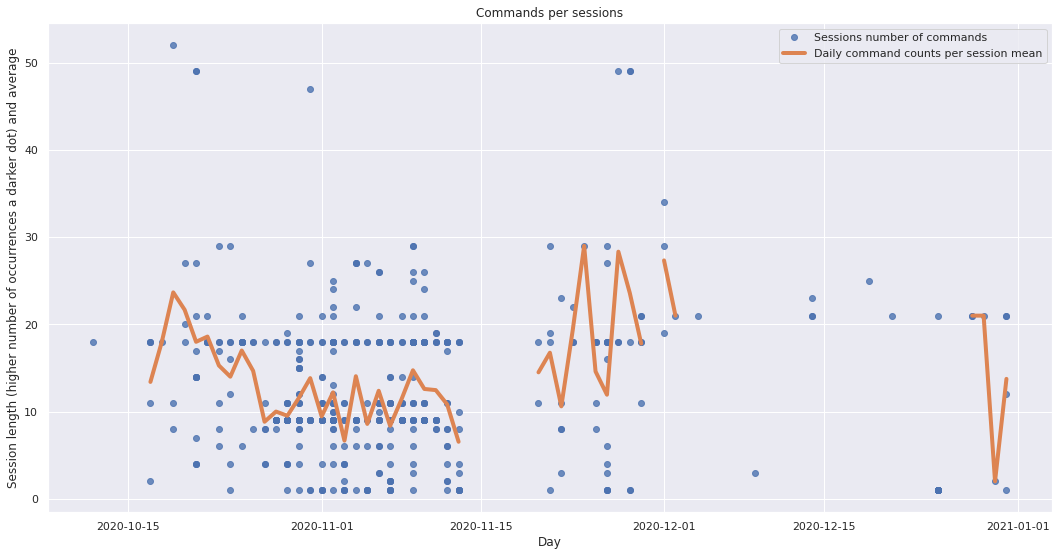

In [66]:
fig, ax = plt.subplots()

ax.plot(df_counts_sessions['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Sessions number of commands')
ax.plot(daily_mean_sessions['n'], linewidth=4, label='Daily command counts per session mean')
#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Session length (higher number of occurrences a darker dot) and average')
ax.set_title('Commands per sessions');

In [38]:
# create dataframe with just the wget, scp, ftp....download commands and plot
# them over time just as the previous one. How many appearences of these commands over time

df_downloads = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df


# down_commands_re.search(row[1]['input'])

down_commands_re = re.compile('wget|tftp|curl|nc|scp|sftp|ssh|ftpget')
for row in df2.iterrows():
    
    # for each different session (each line one session)
    # if not it the new df_downloads dataframe, count down_commands and insert
    if (row[1]['session'] not in df_downloads['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        commands = df2.loc[df2['session'] == row[1]['session']]
        # print(commands)
        # print(commands[commands['input'].str.count(down_commands_re)==1].shape[0])
        # print(commands[commands['input'].str.count(down_commands_re)==1])
        n = commands[commands['input'].str.count(down_commands_re)==1].shape[0]

        df_downloads = df_downloads.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    

df_downloads.timestamp = pd.to_datetime(df_downloads.timestamp, format='%Y-%m-%d')
df_downloads = df_downloads.sort_values('timestamp')   
df_downloads = df_downloads.set_index('timestamp')
    
df_downloads


,session,n
timestamp,,
2020-10-12,ab7d16c2799c,2
2020-10-17,9b3f39ff2260,0
2020-10-17,f7f6ed4c7267,0
2020-10-17,3b6caf0f2bcd,2
2020-10-17,f0b9c9a76373,2
...,...,...
2020-12-31,8ea922fa78fa,1
2020-12-31,3eea8f49d932,1
2020-12-31,5e63a5a7ffba,0


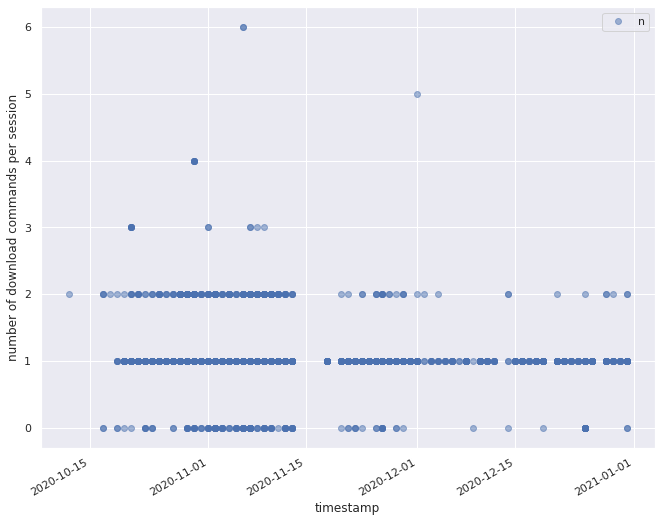

In [39]:
cols_plot = ['session', 'n']
axes = df_downloads[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('number of download commands per session')

In [40]:
daily_mean_downloads = df_downloads.astype({'n': 'int'}).resample('D').mean()
daily_mean_downloads


daily_total_downloads = df_downloads.astype({'n': 'int'}).resample('D').sum()
daily_total_downloads

,n
timestamp,
2020-10-12,2
2020-10-13,0
2020-10-14,0
2020-10-15,0
2020-10-16,0
...,...
2020-12-27,0
2020-12-28,19
2020-12-29,12


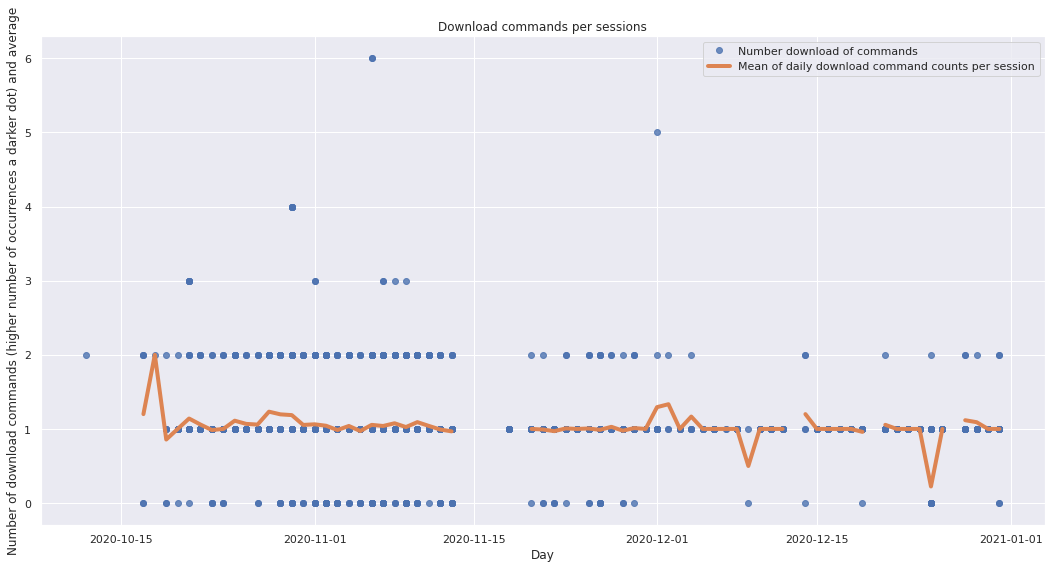

In [67]:
fig, ax = plt.subplots()

ax.plot(df_downloads['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Number download of commands')
ax.plot(daily_mean_downloads['n'], linewidth=4, label='Mean of daily download command counts per session')
#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands (higher number of occurrences a darker dot) and average')
ax.set_title('Download commands per sessions');

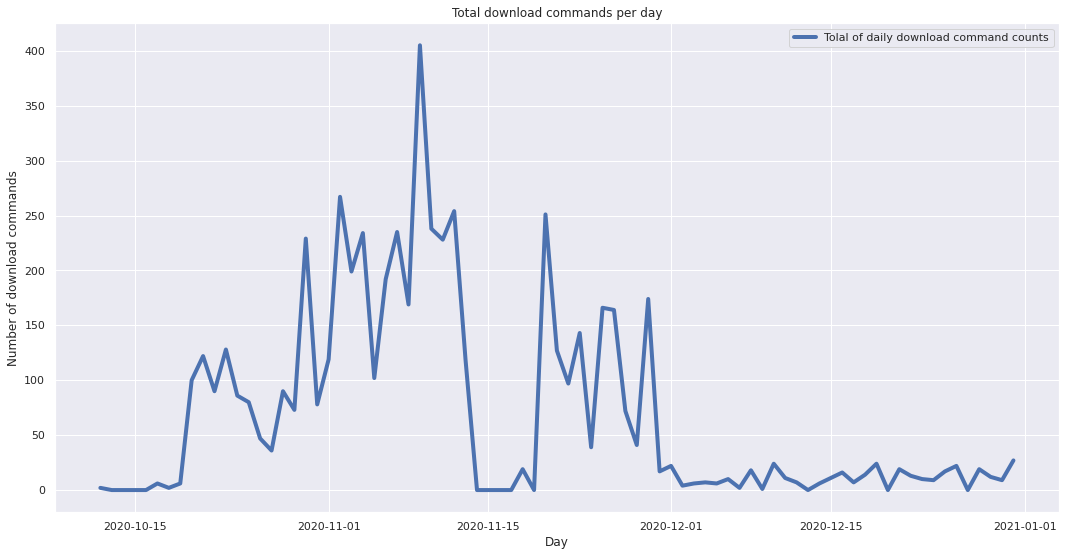

In [42]:
### review, this is not total commands, but total down commands

fig, ax = plt.subplots()

ax.plot(daily_total_downloads['n'], linewidth=4, label='Tolal of daily download command counts')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Total download commands per day');

- **Graph methods**

In [48]:
# create dataframe with shape

# for a given commands dataframe:  
# session1   |    cd home; cat file.txt; wget 1.1.1.1
# session2   |    echo 'a'; rm *

### DF
# input1 input2
# cd      cat
# cat     wget
# echo    rm


commandsdf = df[['session','input']]



data = {'session': '', 'input': ''}
serie = pd.Series(data)
prev_row = (0, serie)

commandsdf2 = pd.DataFrame()
for row in commandsdf.iterrows():
    if row[1]['session'] == prev_row[1]['session']:
        commandsdf2 = commandsdf2.append({'previous': prev_row[1]['input'], 'next': row[1]['input']},
                                         ignore_index=True)
        
    prev_row = row

print(commandsdf2)

                next previous
0             system   enable
1              shell   system
2                 sh    shell
3                cat       sh
4       /bin/busybox      cat
...              ...      ...
160706          echo   passwd
160707          grep     echo
160708          head     grep
160709           cat     head
160710           awk      cat

[160711 rows x 2 columns]


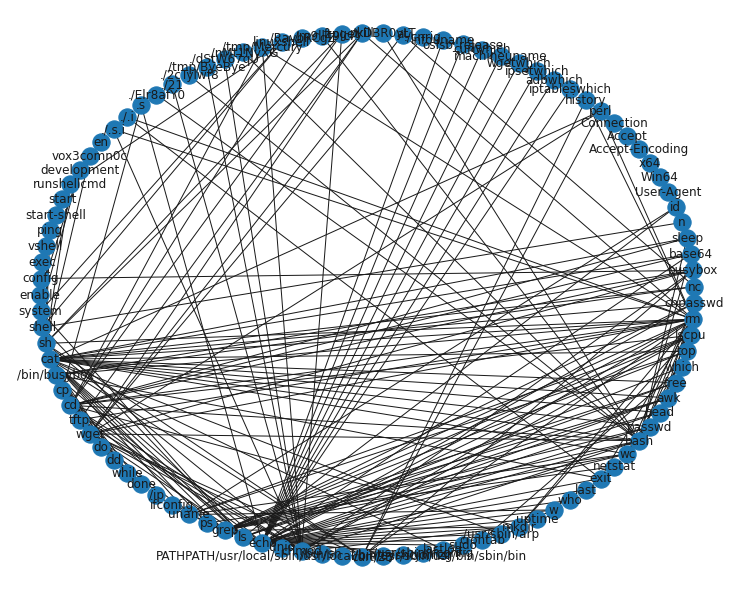

In [49]:
# graph longest session in a graph diagram using resource
# https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
# shall create a list of commands and the next command

G = nx.Graph()
G = nx.from_pandas_edgelist(commandsdf2, 'previous', 'next')

from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)


In [45]:
G['wget']

AtlasView({'tftp': {}, '/bin/busybox': {}, 'do': {}, 'PATHPATH/usr/local/sbin/usr/local/bin/usr/sbin/usr/bin/sbin/bin': {}, 'curl': {}, 'chmod': {}, 'cd': {}, 'rm': {}, 'busybox': {}, 'done': {}, 'dd': {}, 'cat': {}, 'perl': {}, 'sh': {}, './cnrig': {}, 'at': {}, 'pkill': {}, 'ls': {}, 'cp': {}, 'bash': {}, 'uname': {}})

In [46]:
len(G['wget'])

21

- Finding most relevant commands (the ones that have more edges)

In [47]:
sorted(dict(G.degree()).items(), key = lambda x : x[1], reverse = True)[:15]

[('echo', 37),
 ('cat', 32),
 ('rm', 24),
 ('cd', 21),
 ('wget', 21),
 ('grep', 21),
 ('chmod', 21),
 ('bash', 19),
 ('sh', 18),
 ('/bin/busybox', 18),
 ('ls', 13),
 ('uname', 12),
 ('tftp', 11),
 ('head', 11),
 ('awk', 11)]